In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [57]:
n=500
m=2#三个亚组
P=2
weight=[0.3,0.7]
mean=[-2,2]
covs=[1,1]#标准差
Theta=np.array([weight,mean,covs])
Theta#混合高斯分布的参数，mean越靠近且离散程度越大，区分的难度越大
p1=int(n*weight[0])
p2=int(n*weight[1])

In [58]:
np.random.seed(12)
mu=np.array([0,0])
cov=np.array([[2,0.5],[0.5,2]])
x=np.random.multivariate_normal(mu,cov,n,check_valid='raise')
betat=np.random.uniform(0,1,P)
betat

array([0.85580788, 0.06527775])

In [59]:
np.random.seed(123)
aa=np.random.normal(mean[0],covs[0],p1)
bb=np.random.normal(mean[1],covs[1],p2)
gamma=np.zeros((n,2))#随机效应的具体取值，第二列为所属亚组
gamma[:,0]=np.hstack((aa,bb))
gamma[:p1,1]=0
gamma[-p2:,1]=1

In [60]:
y=np.zeros((n,2))
for i in range(n):
        y[i,0]=np.dot(x[i],betat)+gamma[i,0]
        y[i,1]=gamma[i,1]

In [61]:
model = LinearRegression() # 构建线性模型
model.fit(x, y[:,0]) # 自变量在前，因变量在后
coef = model.coef_ # 斜率
intercept = model.intercept_ # 截距
print(model.coef_, model.intercept_) # 输出斜率和截距

[0.65223898 0.10295666] 0.7661868733901454


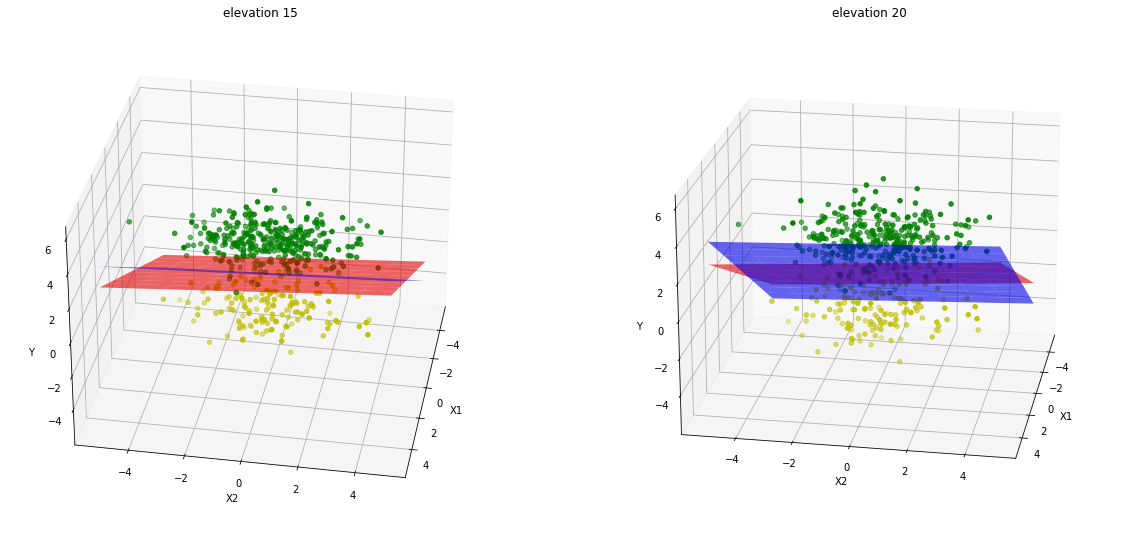

In [78]:
fig = plt.figure(figsize=(20,10))

xm = np.linspace(-5, 5,10)
ym = np.linspace(-5, 5,10)
X, Y = np.meshgrid(xm, ym)

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X,Y,Z=betat[0]*X+betat[1]*Y, color='b',alpha=0.6)
ax1.plot_surface(X,Y,Z=coef[0]*X+coef[1]*Y, color='r',alpha=0.6)
ax1.scatter(x[:p1,0],x[:p1,1], y[:p1,0], c='y')  # 绘制数据点
ax1.scatter(x[-p2:,0],x[-p2:,1], y[-p2:,0], c='g')
ax1.set_zlabel('Y')  # 坐标轴
ax1.set_ylabel('X2')
ax1.set_xlabel('X1')
ax1.view_init(elev=30,    # 仰角
            azim=10)   # 方位角
ax1.set_title('elevation 15')

ax2 = fig.add_subplot(122, projection='3d')  # 创建一个三维的绘图工程度
ax2.scatter(x[:p1,0],x[:p1,1], y[:p1,0], c='y')  # 绘制数据点
ax2.scatter(x[-p2:,0],x[-p2:,1], y[-p2:,0], c='g')
ax2.plot_surface(X,Y,Z=betat[0]*X+betat[1]*Y, color='b',alpha=0.6)
ax2.plot_surface(X,Y,Z=coef[0]*X+coef[1]*Y, color='r',alpha=0.6)
ax2.set_zlabel('Y')  # 坐标轴
ax2.set_ylabel('X2')
ax2.set_xlabel('X1')
ax2.view_init(elev=20,    # 仰角
            azim=10)   # 方位角
ax2.set_title('elevation 20')

plt.show()

In [63]:
def normal(x,theta):
    mu=theta[0]
    s=theta[1]#标准差
    result=(1/(np.sqrt(2*np.pi)*s))*np.exp(-1*(x-mu)**2/(2*s**2))
    return result

def mixnormal(x,theta):
    m=theta.shape[0]
    result=0
    for i in range(m):
        result+=theta[0,1]*normal(x,theta[1:,i])
    return result


In [64]:
data0=np.zeros(n)
for i in range(n):
    data0[i]=y[i,0]-np.dot(x[i],coef)

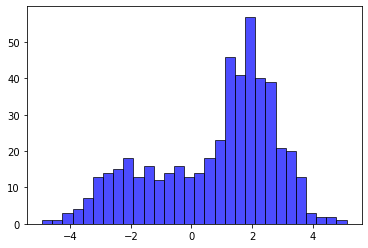

In [111]:
plt.hist(data0, bins=30,  facecolor="blue", edgecolor="black", alpha=0.7)
plt.show()

datat=np.zeros(n)
for i in range(n):
    datat[i]=y[i,0]-np.dot(x[i],betat)

In [66]:
smean=np.mean(data0)
sstd=np.std(data0)
ssvar=np.var(data0)
stheta0=np.array([smean,sstd])
stheta0#样本均值与样本的标准差

array([0.76618687, 2.01467494])

In [85]:
#假设通过某些方法得到一个较好的初值
beta0=coef
weight0=[0.2,0.8]
mean0=[-2,2]
covs0=[1,1]
theta0=np.array([weight0,mean0,covs0])

In [16]:
def ps(x,y,an=0.25):#对方差的惩罚函数
    z=-an*(np.log(x**2/y**2)+(y**2/x**2)-1)
    return z

def ln(x,t1,t2,α):#单个样本的混合正态的对数似然
    n=x.shape[0]
    y=np.zeros(n)
    for i in range(n):
        y[i]=np.log(mixnormal(x[i],t1,t2,α))
    return y

def pl(x,t1,t2,α):#混合正态的惩罚联合对数似然
    y=np.sum(ln(x,t1,t2,α))+ps(t1[1],svar)+ps(t2[1],svar)
    return y

In [55]:
theta0.shape[1]

2

In [68]:
def Lih(X,theta):
    num=X.shape[0]
    C=theta.shape[1]
    Ga=np.zeros((num,C))
    c=np.zeros(C)

    for j in range(num):#响应度
        for k in range(C):
            c[k]=theta[0,k]*normal(X[j],theta[1:,k])
        Ga[j]=c/np.sum(c)

    return Ga

def Betanxt(betaold,thetaold,Xs,Y,t=1):#定义了一个联系两次牛顿法迭代的函数
    P=Xs.shape[1]
    num=Xs.shape[0]
    data=Y-np.dot(Xs,betaold.T)
    L=Lih(data,thetaold)

    firstorder=np.zeros(P)
    for p in range(P):
        a=0
        for h in range (m):
            for i in range(num):
                a += (((L[i,h])/(thetaold[2,h]**2))*((data[i]-thetaold[1,h]))*(Xs[i,p]))
        firstorder[p]=a

    secorder=np.zeros((P,P))
    for k in range(P):#这里为对称矩阵，其实可以加速
        for l in range(k,P):
            a=0
            for h in range (m):
                for i in range(n):
                    a += (((L[i,h])/(thetaold[2,h]**2))*((Xs[i,k])*(Xs[i,l])))
            secorder[k,l]=a
            secorder[l,k]=a

    invsecorder=np.linalg.inv(secorder)
    direction=np.dot(invsecorder,firstorder)
    λ2=np.dot(firstorder.T,direction)
    betanxt=betaold-t*direction
    return betanxt,λ2/2,t

In [97]:
theta0

array([[ 0.2,  0.8],
       [-2. ,  2. ],
       [ 1. ,  1. ]])

In [112]:
def Betanxt(betanow,thetaold,Xs,Y,t=1):#定义了一个联系两次牛顿法迭代的函数
    P=Xs.shape[1]
    num=Xs.shape[0]
    data=Y-np.dot(Xs,betanow.T)
    L=Lih(data,thetaold)
    C=thetaold.shape[1]

    firstorder=np.zeros(P)
    for h in range (C):
        for i in range(num):
            firstorder += (((L[i,h])/(thetaold[2,h]**2))*((data[i]-thetaold[1,h]))*(Xs[i]))

    secorder=np.zeros((P,P))
    for k in range(P):#这里为对称矩阵
        for l in range(k,P):
            a=0
            for h in range (C):
                for i in range(n):
                    a += (((L[i,h])/(thetaold[2,h]**2))*((Xs[i,k])*(Xs[i,l])))
            secorder[k,l]=a
            secorder[l,k]=a

    invsecorder=np.linalg.inv(secorder)
    direction=np.dot(invsecorder,firstorder.T)
    λ2=np.dot(firstorder,direction)
    betanxt=betanow+t*direction
    return betanxt,λ2/2,t

In [99]:
def Betaout(betazero,thetazero,Xs,Y,t0=1.,ε=0.05,N=1000):#这里给了牛顿法一个循环上界N
    out=[betazero,100,t0]
    for i in range(N):
        out=Betanxt(out[0],thetazero,Xs,Y,out[2])
        if out[1]<=ε:
            break 
    return out,i+1

In [71]:
betat

array([0.85580788, 0.06527775])

In [72]:
beta0

array([0.65223898, 0.10295666])

In [73]:
beta1=np.array([1,1])

In [114]:
Betaout(beta0,theta0,x,y[:,0],t0=0.05,ε=0.05,N=100)

((array([0.82925907, 0.05154524]), 0.04851212563080057, 0.05), 82)

def thetanxt(Xs,Y,thetaold,betaold,betanew,tp=0.25):
    num=Xs.shape[0]
    data=Y-np.dot(Xs,betaold.T)
    datanew=Y-np.dot(Xs,betanew.T)
    svar=np.std(datanew)
    Ga=Lih(data,thetaold)
    d=np.zeros(m)
    thetanew=np.zeros((3,m))

    for k in range(m):#更新参数
        d[k]=np.sum(Ga[:,k])
        thetanew[0,k]=d[k]/num
        thetanew[1,k]=np.dot(Ga[:,k],datanew[:])/d[k]
        thetanew[2,k]=np.sqrt((np.dot(Ga[:,k],(datanew[:]-thetanew[1,k])**2)+2*tp*svar)/(d[k]+2*tp))#标准差

def Q(thetaold,Xs,Y,betaold,betanew,tp=0.25):
    Q=0
    num=Xs.shape[0]
    data=Y-np.dot(Xs,betaold.T)
    datanew=Y-np.dot(Xs,betanew.T)
    svar=np.std(datanew)
    Ga=Lih(data,thetaold)
    d=np.zeros(m)
    thetanew=np.zeros((3,m))

    for k in range(m):#更新参数
        d[k]=np.sum(Ga[:,k])
        thetanew[0,k]=d[k]/num
        thetanew[1,k]=np.dot(Ga[:,k],datanew[:])/d[k]
        thetanew[2,k]=np.sqrt((np.dot(Ga[:,k],(datanew[:]-thetanew[1,k])**2)+2*tp*svar)/(d[k]+2*tp))#标准差

    '''
    for h in range(m):
        for i in range(num):
            Q+=(d[h]/num)*(np.log(thetanew[1,h]))+(Ga[i,h])*(np.log(normal(datanew[i],thetanew[1:,h])))-(tp/num)*ps(thetanew[2,h],svar,tp)
'''
    return thetanew


In [44]:
beta1=Betanxt(beta0,theta0,x,y[:,0],t=1)[0]

In [45]:
beta1

array([0.7998672 , 0.69386494])

In [46]:
Q(theta0,x,y[:,0],beta0,beta1,tp=0.25)

array([[ 0.26279657,  0.73720343],
       [-2.08473124,  1.85529624],
       [ 1.1357037 ,  1.10406148]])

In [ ]:
out=[beta0,0,1]
out

((array([0.79988552, 0.71523639]), 0.04128820399136285, 2), 1)

In [ ]:
λ2=np.dot(np.dot(S0.T,np.linalg.inv(S1)),S0)

In [ ]:
betat

In [ ]:
beta0

In [ ]:
beta0-np.dot(np.linalg.inv(S1),S0)

In [108]:
def EM(X,theta):
    num=X.shape[0]
    C=theta.shape[1]
    Ga=np.zeros((num,C))
    c=np.zeros(C)
    d=np.zeros(C)
    thetanext=np.zeros((3,C))
    
    for j in range(num):#响应度
        for k in range(C):
            c[k]=theta[0][k]*normal(X[j],theta[1:,k])
        Ga[j]=c/np.sum(c)

    for k in range(C):#更新参数
        d[k]=np.sum(Ga[:,k])
        thetanext[0,k]=d[k]/num
        thetanext[1,k]=np.dot(Ga[:,k],X[:])/d[k]
        thetanext[2,k]=np.sqrt(np.dot(Ga[:,k],(X[:]-theta[1,k])**2)/d[k])#标准差

    return thetanext

In [104]:
def iterate(X,n,T0):
    for i in range (n):
        T0=EM(X,T0)
    return T0

In [109]:
Thetanew=iterate(data0,50,theta0)
Thetanew

array([[ 0.31427115,  0.68572885],
       [-1.78265479,  1.93432704],
       [ 1.18520248,  0.96612121]])